## Explanation Evaluation

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Add root to path
sys.path.insert(0, str("../"))
sys.path.insert(1, str("../src"))


# Import model metadata
from config.config import settings
from xai_pkg.storage.dynamodb_client import DynamoDBClient
from xai_pkg.model_explainer.predictor import CreditPredictor

predictor = CreditPredictor.load_model()
metadata = predictor.model_metadata

# Set up academic plotting style (matching sampling notebook)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

# Academic color scheme (Stanford colors)
COLORS = {'bar': '#2E86AB', 'accent': '#A23B72', 'neutral': '#F18F01', 'highlight': '#C73E1D'}

# LLM-specific color mapping using Stanford colors
LLM_COLORS = {
    'gemma2-2b': '#2E86AB', 
    'llama3.2-3b': '#A23B72', 
    'mistral-7b': '#F18F01',   
    'gpt-5-mini': '#C73E1D'      
}

# Consistent LLM ordering (by model size)
LLM_ORDER = ['gemma2-2b', 'llama3.2-3b', 'mistral-7b', 'gpt-5-mini']

ALPHA = 1
save_plots = True
output_dir = "../output"

INFO:xai_pkg.model_explainer.predictor:CreditPredictor initialized with XGBoost model
INFO:xai_pkg.model_explainer.predictor:Model loaded from ../output/models/best_model.pkl


### Set custom plotting functions

In [9]:
def plot_metric_by_llm(data, metric_col, title, ylabel, add_value_labels=True, format_func=None, show_error_bars=False):
    data['llm_name'] = pd.Categorical(data['llm_name'], categories=LLM_ORDER, ordered=True)
    fig, ax = plt.subplots()
    colors = [LLM_COLORS[llm] for llm in LLM_ORDER]
    bars = sns.barplot(x='llm_name', y=metric_col, data=data, ax=ax, hue='llm_name', palette=LLM_COLORS, alpha=ALPHA, errorbar=None if not show_error_bars else 'sd', legend=False)
    ax.set_title(title)
    ax.set_xlabel('LLM')
    ax.set_ylabel(ylabel)
    if add_value_labels:
        for i, llm in enumerate(LLM_ORDER):
            llm_data = data[data['llm_name'] == llm]
            if not llm_data.empty:
                mean_val = llm_data[metric_col].mean()
                if not pd.isna(mean_val):
                    label = format_func(mean_val) if format_func else f'{mean_val:.3f}'
                    ax.text(i, mean_val + mean_val*0.01, label, ha='center', va='bottom', fontweight='bold', fontsize=10)
    plt.show()
    return fig, ax

### Load final evaluation results from Dynamo

In [10]:
# Load data from evaluations.json (with summary stats and semscore)
with open('../output/evaluations/evaluations.json', 'r') as f:
    json_data = json.load(f)
    individual_results = json_data['explanations']
    summary_stats = json_data['evaluation_summary']


print(f"Loaded {len(individual_results)} evaluation results from JSON")

# Convert to DataFrame with better control
full_eval_df = pd.json_normalize(individual_results, 
                           record_path=None, 
                           meta=['explanation_id', 'prediction_id', 'llm_name', 'processing_time'],
                           record_prefix='',
                           sep='_')
# Remove the prefix
full_eval_df.columns = full_eval_df.columns.str.replace('evaluation_results_', '')
full_eval_df.columns = full_eval_df.columns.str.replace('counterfactual_verification', 'cf')
full_eval_df.columns = full_eval_df.columns.str.replace('regulatory_compliance_', '')

columns = full_eval_df.columns

for col in columns:
    print(col)

# Select only the columns you actually need for analysis
useful_columns = [
    'explanation_id', 
    'explanation_text',
    'prediction_id', 
    'prediction_outcome',
    'llm_name', 
    'processing_time',
    'cemat_overall_score', 
    'cemat_understandability_score', 
    'cemat_actionability_score',
    'cf_score', 
    'cf_skipped',
    'cf_prediction_flipped', 
    'cf_probability_change',
    'principal_reason_identification_score',
    'individual_specific_content_score', 
    'technical_jargon_check_score',
    'fidelity_score', 
    'technical_features_check_count', 
    'immutable_features_check_count',
    'flesch_kincaid_score',
    'technical_features_check_found_features',
    'immutable_features_check_mentioned_features'
]

cf_baseline_flip_rate = 0.8615384615384616  # 86.2% from DICE validation results model_explainer.ipynb

# Filter to only useful columns
eval_df = full_eval_df[useful_columns].copy()
# Add relative flip rate
eval_df['cf_relative_flip_rate'] = eval_df['cf_prediction_flipped'] / cf_baseline_flip_rate

print(f"Clean DataFrame shape: {eval_df.shape}")

# Print unique LLMs
print(f"Unique LLMs: {eval_df['llm_name'].unique()}")

# Set categorical order for consistent positioning
eval_df['llm_name'] = pd.Categorical(eval_df['llm_name'], categories=LLM_ORDER, ordered=True)

print(f"Created DataFrame with {len(eval_df)} rows and {len(eval_df.columns)} columns")

print(f"Total evaluations: {len(eval_df)}")
print(f"Unique LLMs: {eval_df['llm_name'].nunique()}")
print(f"LLM breakdown:")
llm_counts = eval_df['llm_name'].value_counts()
for llm, count in llm_counts.items():
    print(f"  {llm}: {count}")

# Extract SemScore summary stats for the table
semscore_stats = summary_stats.get('semscore_analysis', {})

Loaded 1200 evaluation results from JSON
prediction_id
cluster_id
timestamp
regeneration_number
explanation_id
llm_name
explanation_text
processing_time
token_usage
error
explanation_timestamp
prediction_outcome
cemat_overall_score
cemat_understandability_items_item_1
cemat_understandability_items_item_2
cemat_understandability_items_item_3
cemat_understandability_items_item_4
cemat_understandability_items_item_5
cemat_understandability_items_item_6
cemat_understandability_items_item_7
cemat_understandability_items_item_8
cemat_understandability_items_item_9
cemat_understandability_items_item_10
cemat_understandability_items_item_11
cemat_understandability_items_item_12
cemat_understandability_items_item_15
cemat_understandability_items_item_16
cemat_understandability_items_item_17
cemat_understandability_items_item_18
cemat_understandability_items_item_19
cemat_actionability_items_item_20
cemat_actionability_items_item_21
cemat_actionability_items_item_22
cemat_actionability_items_ite

## Analysis


LLM: gemma2-2b
{"consumer_explanation": "The main reason for your credit decision is the number of open credit lines. Having too many open credit lines can make it harder to manage your finances and potentially lead to higher interest rates on loans. In this case, you have 15 open credit lines, which is a significant factor in your decision.  It's important to be mindful of how many credit lines you have open at any given time. Try to keep the number of open credit lines below 5 or even 3 if possible. This will help you manage your debt and improve your overall financial health.", "analysis": {"top_features": ["0.4876", "-0.4813", "-0.4408", "-0.2487", "-0.1541", "-0.1349", "-0.0825", "-0.0722", "-0.0710", "-0.0018"]}}
No rejected example found.

LLM: llama3.2-3b
{"consumer_explanation": "To improve your chances of approval, focus on reducing your credit card usage. Currently, you use 5.1% of your available credit, which is relatively low. However, the lender considers a lower utiliza

## Print example explanations

In [14]:
for llm in LLM_ORDER:
    print(f"\nLLM: {llm}")
    approved = eval_df[(eval_df['llm_name'] == llm) & (eval_df['prediction_outcome'] == 'approved')]
    rejected = eval_df[(eval_df['llm_name'] == llm) & (eval_df['prediction_outcome'] == 'declined')]

    if not approved.empty:
        print(f"Positive Explanation: {approved.iloc[0]['explanation_text']}")
    if not rejected.empty:
        print(f"Negative Explanation: {rejected.iloc[0]['explanation_text']}")


LLM: gemma2-2b
Positive Explanation: {"consumer_explanation": "The main reason for your credit decision is the number of open credit lines. Having too many open credit lines can make it harder to manage your finances and potentially lead to higher interest rates on loans. In this case, you have 15 open credit lines, which is a significant factor in your decision.  It's important to be mindful of how many credit lines you have open at any given time. Try to keep the number of open credit lines below 5 or even 3 if possible. This will help you manage your debt and improve your overall financial health.", "analysis": {"top_features": ["0.4876", "-0.4813", "-0.4408", "-0.2487", "-0.1541", "-0.1349", "-0.0825", "-0.0722", "-0.0710", "-0.0018"]}}
Negative Explanation: {"consumer_explanation": "Based on your application, the most important factor impacting your credit decision was your number of open credit lines. Having 14 open credit lines is a significant amount compared to the average ap

## Metric results overview

In [ ]:
# Get summary table with all metrics per LLM

metrics_config = {
    'cf_prediction_flipped': {'name': 'CF Prediction Flip rate', 'format': '{:.1%}'},
    'cf_relative_flip_rate': {'name': 'CF Relative Flip Rate', 'format': '{:.1%}'},
    'cf_probability_change': {'name': 'CF Default Probability Change', 'format': '{:.3f}'},
    'cemat_understandability_score': {'name': 'CEMAT Understandability', 'format': '{:.1%}'},
    'cemat_actionability_score': {'name': 'CEMAT Actionability', 'format': '{:.1%}'},
    'cemat_overall_score': {'name': 'CEMAT Overall', 'format': '{:.1%}'},
    'principal_reason_identification_score': {'name': 'Regulatory Principal Reason', 'format': '{:.1%}'},
    'individual_specific_content_score': {'name': 'Regulatory Individual Specific', 'format': '{:.1%}'},
    'technical_jargon_check_score': {'name': 'Regulatory Technical Jargon', 'format': '{:.1%}'},
    'fidelity_score': {'name': 'Fidelity', 'format': '{:.2f}'},
    'technical_features_check_count': {'name': 'Technical Features', 'format': '{:.2f}'},
    'immutable_features_check_count': {'name': 'Immutable Features', 'format': '{:.2f}'},
    'flesch_kincaid_score': {'name': 'Flesch-Kincaid', 'format': '{:.2f}'},
    'processing_time': {'name': 'Processing Time (s)', 'format': '{:.1f}'}
}

summary_data = []
for metric_col, config in metrics_config.items():
    row = {'Metric': config['name']}
    for llm in LLM_ORDER:
        llm_data = eval_df[eval_df['llm_name'] == llm]
        mean_val = llm_data[metric_col].mean()
        row[llm] = config['format'].format(mean_val) if pd.notnull(mean_val) else ""
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df[['Metric'] + LLM_ORDER]
display(summary_df)

if save_plots:
    excel_path = f'{output_dir}/evaluations/metrics_summary_by_llm.xlsx'
    summary_df.to_excel(excel_path, index=False, sheet_name='Metrics Summary')
    print(f"\n📁 Summary table exported to: {excel_path}")

,Metric,gemma2-2b,llama3.2-3b,mistral-7b,gpt-5-mini
0,CF Prediction Flip rate,47.7%,79.6%,65.7%,89.2%
1,CF Relative Flip Rate,55.4%,92.4%,76.2%,103.6%
2,CF Default Probability Change,-0.164,-0.277,-0.251,-0.296
3,CEMAT Understandability,80.0%,76.4%,83.3%,79.5%
4,CEMAT Actionability,57.6%,55.9%,59.8%,65.3%
5,CEMAT Overall,72.6%,69.5%,75.9%,74.8%
6,Regulatory Principal Reason,100.0%,80.0%,95.0%,97.3%
7,Regulatory Individual Specific,95.7%,97.3%,99.0%,100.0%
8,Regulatory Technical Jargon,83.3%,57.7%,84.7%,70.0%
9,Fidelity,0.55,0.88,0.77,1.00



📁 Summary table exported to: ../output/evaluations/metrics_summary_by_llm.xlsx


## 1. Counterfactuals verification

#### 1.1 Validity rate by LLM

In [ ]:
cf_evaluated = eval_df['cf_prediction_flipped'].notna().sum()
cf_skipped = eval_df['cf_skipped'].sum()
cf_successful = eval_df['cf_prediction_flipped'].sum()

print(f"CF evaluations (rejected customers): {cf_evaluated}")
print(f"CF skipped (approved customers): {cf_skipped}")  
print(f"CF successful prediction flips: {cf_successful}")

if cf_evaluated > 0:
    success_rate = cf_successful / cf_evaluated
    print(f"CF success rate: {success_rate:.2%}")
    
    # Average probability change
    avg_prob_change = eval_df[eval_df['cf_prediction_flipped'].notna()]['cf_probability_change'].mean()
    print(f"Average probability change: {avg_prob_change:.3f}")
    
    # By LLM model
    print(f"\nCounterfactual verification by LLM:")
    for llm in eval_df['llm_name'].unique():
        llm_data = eval_df[eval_df['llm_name'] == llm]
        llm_cf = llm_data[llm_data['cf_prediction_flipped'].notna()]
        if len(llm_cf) > 0:
            llm_success_rate = llm_cf['cf_prediction_flipped'].sum() / len(llm_cf)
            llm_avg_score = llm_cf['cf_prediction_flipped'].mean()
            print(f"  {llm}: success_rate={llm_success_rate:.2%}, avg_score={llm_avg_score:.3f} (n={len(llm_cf)})")

CF evaluations (rejected customers): 724
CF skipped (approved customers): 420
CF successful prediction flips: 516
CF success rate: 71.27%
Average probability change: -0.249

Counterfactual verification by LLM:
  llama3.2-3b: success_rate=79.57%, avg_score=0.796 (n=186)
  gemma2-2b: success_rate=47.70%, avg_score=0.477 (n=174)
  gpt-5-mini: success_rate=89.23%, avg_score=0.892 (n=195)
  mistral-7b: success_rate=65.68%, avg_score=0.657 (n=169)


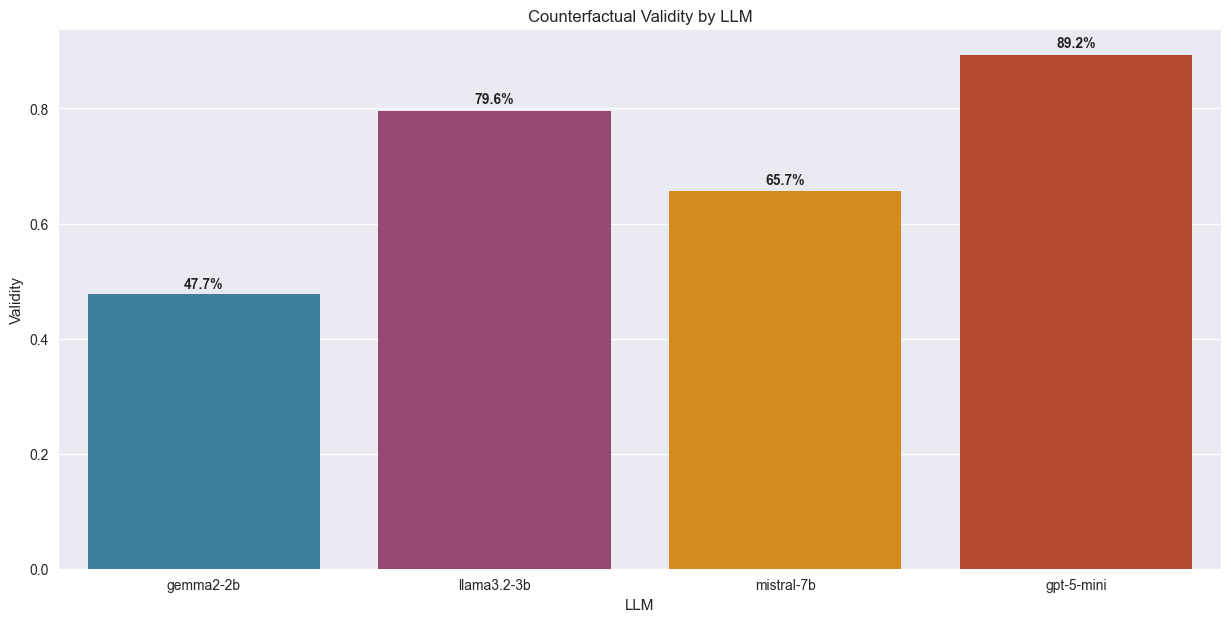

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Counterfactual Validity by LLM'}, xlabel='LLM', ylabel='Validity'>)

In [ ]:

plot_metric_by_llm(
    eval_df, 
    'cf_prediction_flipped', 
    'Counterfactual Validity by LLM', 
    'Validity',
    format_func=lambda x: f'{x:.1%}'
)


#### 1.3 Probability change by LLM

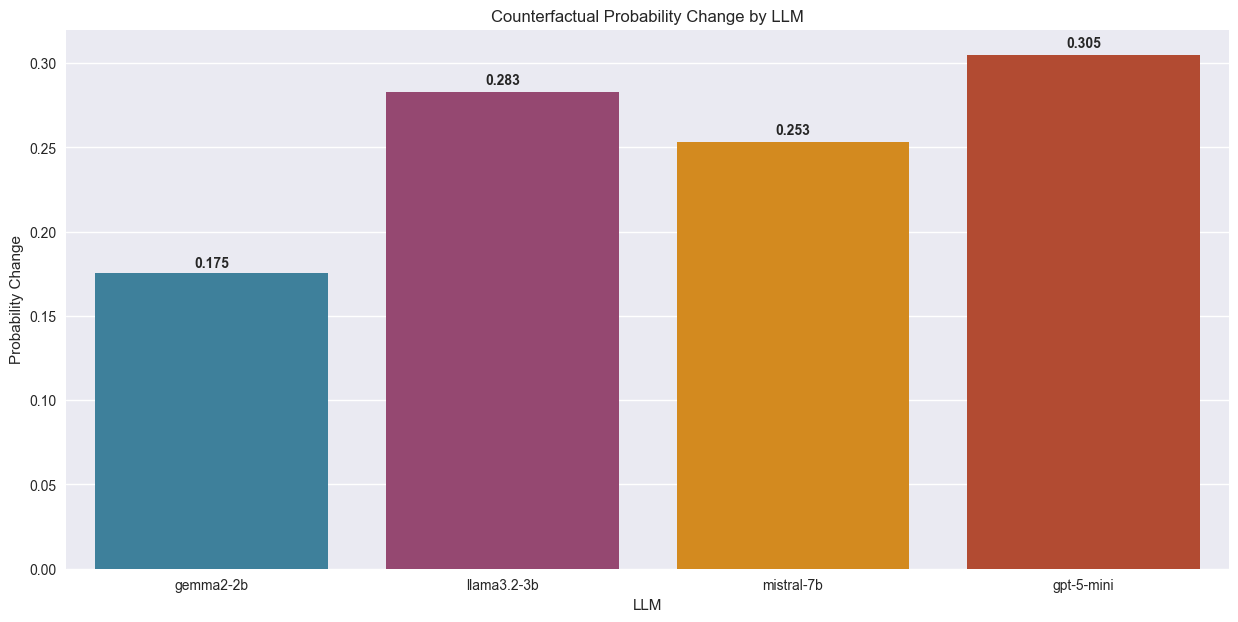

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Counterfactual Probability Change by LLM'}, xlabel='LLM', ylabel='Probability Change'>)

In [ ]:
# Plot probability change by LLM

plot_metric_by_llm(
    eval_df.assign(cf_probability_change=eval_df['cf_probability_change'].abs()),
    'cf_probability_change',
    'Counterfactual Probability Change by LLM',
    'Probability Change',
    format_func=lambda x: f'{x:.3f}'
)

## 2. CEMAT

### 2.1 Create CEMAT df

In [ ]:
# Create cemat items 
cemat_item_columns = [col for col in full_eval_df.columns if col.startswith('cemat_') and 'items_item_' in col]
add_info_cols = ['llm_name', 'cemat_overall_score', 'cemat_understandability_score', 'cemat_actionability_score']
print(f"Individual CEMAT items available: {len(cemat_item_columns)}")

cemat_df = full_eval_df[cemat_item_columns + add_info_cols]

# Create item descriptions based on the CEMAT framework
item_descriptions = {
    # Understandability items (1-19)
    'cemat_understandability_items_item_1': 'Makes purpose completely evident',
    'cemat_understandability_items_item_2': 'No distracting information',
    'cemat_understandability_items_item_3': 'Uses common, everyday language',
    'cemat_understandability_items_item_4': 'Financial terms defined when used',
    'cemat_understandability_items_item_5': 'Uses active voice',
    'cemat_understandability_items_item_6': 'Numbers clear and easy to understand',
    'cemat_understandability_items_item_7': 'No calculations expected from user',
    'cemat_understandability_items_item_8': 'Breaks information into short sections',
    'cemat_understandability_items_item_9': 'Sections have informative headers',
    'cemat_understandability_items_item_10': 'Presents information in logical sequence',
    'cemat_understandability_items_item_11': 'Provides summary',
    'cemat_understandability_items_item_12': 'Uses visual cues for key points',
    'cemat_understandability_items_item_15': 'Uses visual aids when helpful',
    'cemat_understandability_items_item_16': 'Visual aids reinforce content',
    'cemat_understandability_items_item_17': 'Visual aids have clear titles/captions',
    'cemat_understandability_items_item_18': 'Illustrations clear and uncluttered',
    'cemat_understandability_items_item_19': 'Simple tables with clear headings',
    
    # Actionability items (20-26)
    'cemat_actionability_items_item_20': 'Clearly identifies at least one action',
    'cemat_actionability_items_item_21': 'Addresses user directly for actions',
    'cemat_actionability_items_item_22': 'Breaks actions into manageable steps',
    'cemat_actionability_items_item_23': 'Provides tangible tools when helpful',
    'cemat_actionability_items_item_24': 'Provides calculation instructions',
    'cemat_actionability_items_item_25': 'Explains how to use charts/graphs',
    'cemat_actionability_items_item_26': 'Uses visual aids for easier action'
}

# Create summary DataFrame
cemat_summary_data = []

# Add overall scores first (much cleaner approach)
overall_metrics = [
    ('cemat_overall_score', 'Overall CEMAT Score', 'Overall Score'),
    ('cemat_understandability_score', 'Overall Understandability', 'Overall Score'),
    ('cemat_actionability_score', 'Overall Actionability', 'Overall Score')
]

for metric_col, description, category in overall_metrics:
    row = {
        'Item': 'Overall',
        'Description': description,
        'Category': category
    }
    
    # Calculate average score per LLM (ignore NAs)
    for llm in LLM_ORDER:
        llm_data = cemat_df[cemat_df['llm_name'] == llm]
        if not llm_data.empty and metric_col in llm_data.columns:
            mean_val = llm_data[metric_col].mean()
            if not pd.isna(mean_val):
                row[llm] = f'{mean_val:.3f}'
            else:
                row[llm] = 'N/A'
        else:
            row[llm] = 'N/A'
    
    cemat_summary_data.append(row)

# Add individual items
for item_col in sorted(cemat_item_columns, key=lambda x: int(x.split('_')[-1])):
    if item_col in cemat_df.columns:
        item_num = item_col.split('_')[-1]
        description = item_descriptions.get(item_col, f'Item {item_num}')
        
        row = {
            'Item': f'Item {item_num}',
            'Description': description,
            'Category': 'Understandability' if 'understandability' in item_col else 'Actionability'
        }
        
        # Calculate average score per LLM
        for llm in LLM_ORDER:
            llm_data = cemat_df[cemat_df['llm_name'] == llm]
            if not llm_data.empty and item_col in llm_data.columns:
                # Get the raw values (don't convert to numeric yet)
                item_values = llm_data[item_col]
                
                # Check if all values are 'N/A' (string)
                if item_values.astype(str).str.upper().eq('N/A').all():
                    row[llm] = 'N/A'
                else:
                    # Convert to numeric, treating 'N/A' as NaN
                    item_data = pd.to_numeric(item_values, errors='coerce')
                    # Only calculate mean if we have at least one non-NaN value
                    valid_values = item_data.dropna()
                    if len(valid_values) > 0:
                        mean_val = valid_values.mean()
                        row[llm] = f'{mean_val:.3f}'
                    else:
                        row[llm] = 'N/A'
            else:
                row[llm] = 'N/A'
        
        cemat_summary_data.append(row)

# Create DataFrame
cemat_summary_df = pd.DataFrame(cemat_summary_data)

# Reorder columns to match LLM_ORDER
expected_columns = ['Item', 'Description', 'Category'] + LLM_ORDER
available_columns = [col for col in expected_columns if col in cemat_summary_df.columns]
cemat_summary_df = cemat_summary_df[available_columns]

# Display the summary
print(f"\nCEMAT Items Summary (Average Scores per Item across LLMs):")
print(f"Total items: {len(cemat_summary_df)}")
print(f"Overall scores: {len(cemat_summary_df[cemat_summary_df['Category'] == 'Overall Score'])}")
print(f"Understandability items: {len(cemat_summary_df[cemat_summary_df['Category'] == 'Understandability'])}")
print(f"Actionability items: {len(cemat_summary_df[cemat_summary_df['Category'] == 'Actionability'])}")

# Display with better formatting
display(cemat_summary_df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}))

# Export to Excel
if save_plots:
    excel_path = f'{output_dir}/evaluations/cemat_items_summary.xlsx'
    cemat_summary_df.to_excel(excel_path, index=False, sheet_name='CEMAT Items Summary')
    print(f"\n📁 CEMAT items summary exported to: {excel_path}")


Individual CEMAT items available: 24

CEMAT Items Summary (Average Scores per Item across LLMs):
Total items: 27
Overall scores: 3
Understandability items: 17
Actionability items: 7


,Item,Description,Category,gemma2-2b,llama3.2-3b,mistral-7b,gpt-5-mini
0,Overall,Overall CEMAT Score,Overall Score,0.726,0.695,0.759,0.748
1,Overall,Overall Understandability,Overall Score,0.800,0.764,0.833,0.795
2,Overall,Overall Actionability,Overall Score,0.576,0.559,0.598,0.653
3,Item 1,Makes purpose completely evident,Understandability,0.993,0.937,1.000,0.997
4,Item 2,No distracting information,Understandability,0.980,0.953,0.993,0.980
5,Item 3,"Uses common, everyday language",Understandability,0.997,0.920,0.990,0.970
6,Item 4,Financial terms defined when used,Understandability,0.477,0.233,0.607,0.453
7,Item 5,Uses active voice,Understandability,0.810,0.950,0.947,0.913
8,Item 6,Numbers clear and easy to understand,Understandability,0.996,0.965,0.986,1.000
9,Item 7,No calculations expected from user,Understandability,1.000,0.997,0.993,1.000



📁 CEMAT items summary exported to: ../output/evaluations/cemat_items_summary.xlsx


## 3. Regulatory Compliance


=== REGULATORY COMPLIANCE ===
principal_reason_identification_score: 0.931
individual_specific_content_score: 0.980
technical_jargon_check_score: 0.739
technical_features_check_count: 0.000
immutable_features_check_count: 0.322


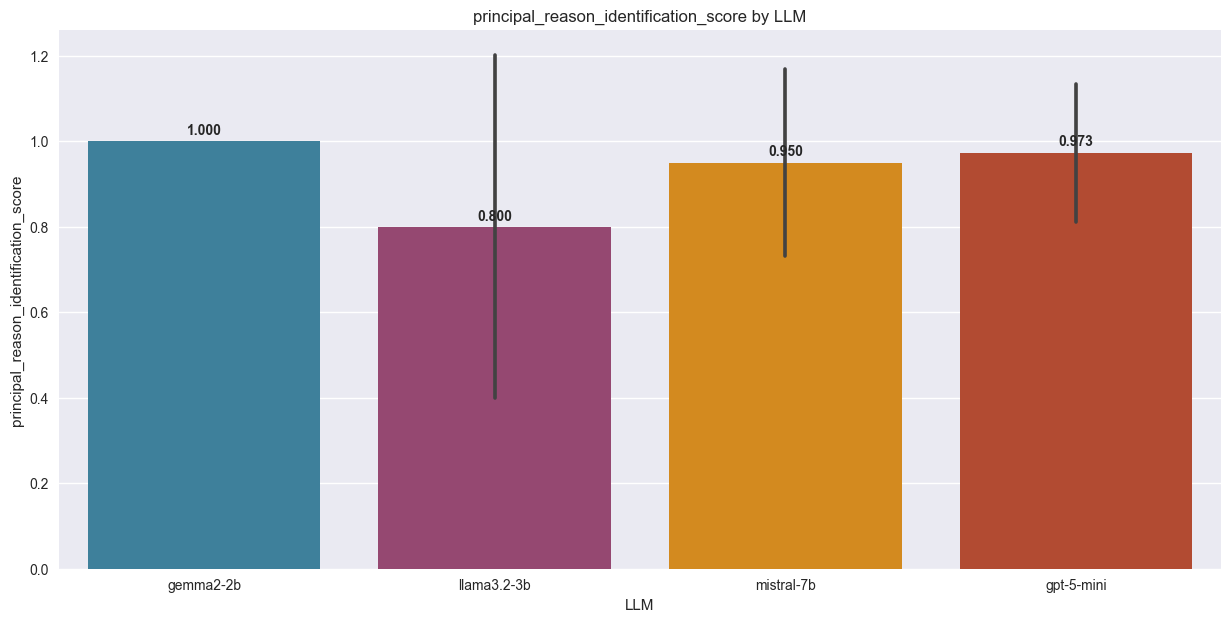

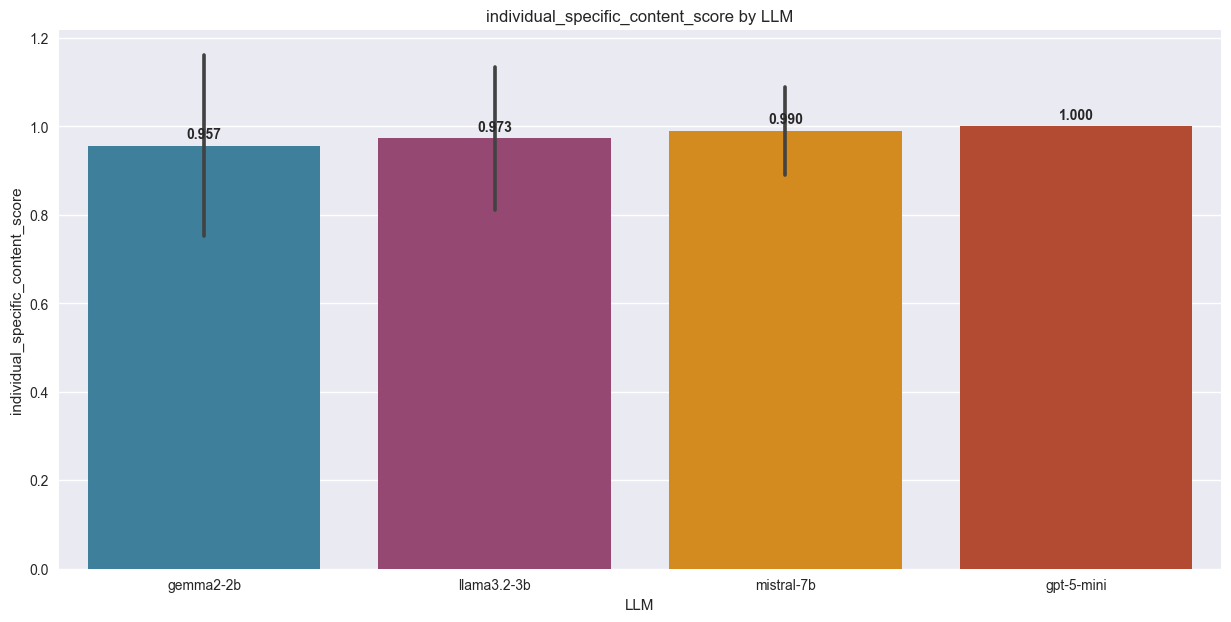

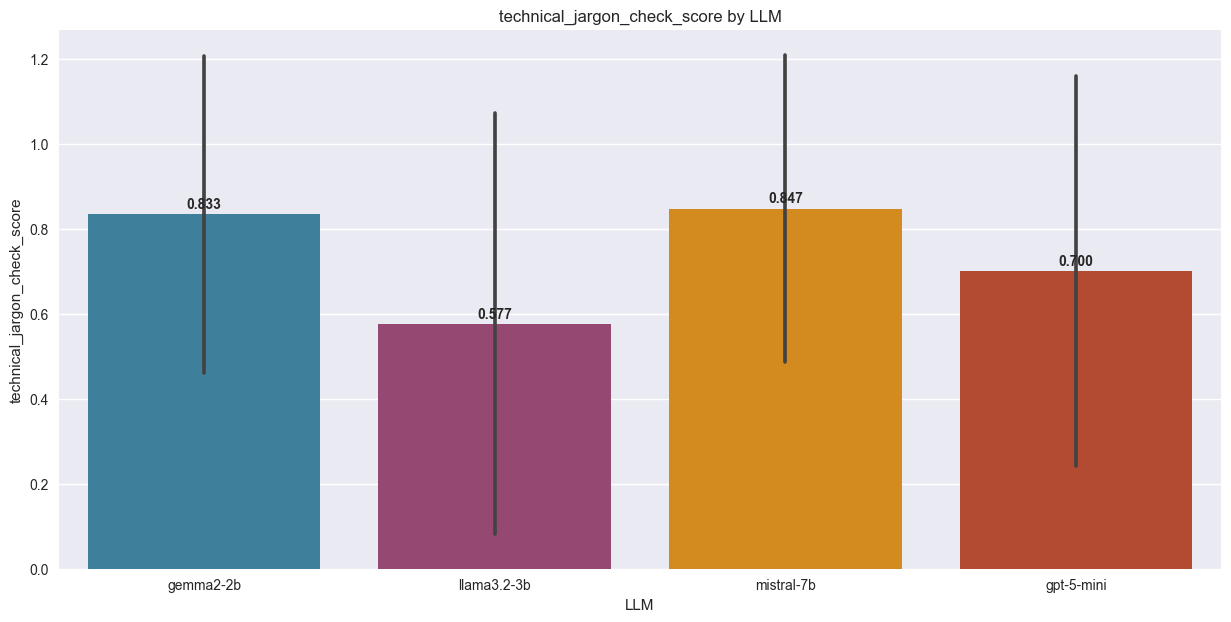

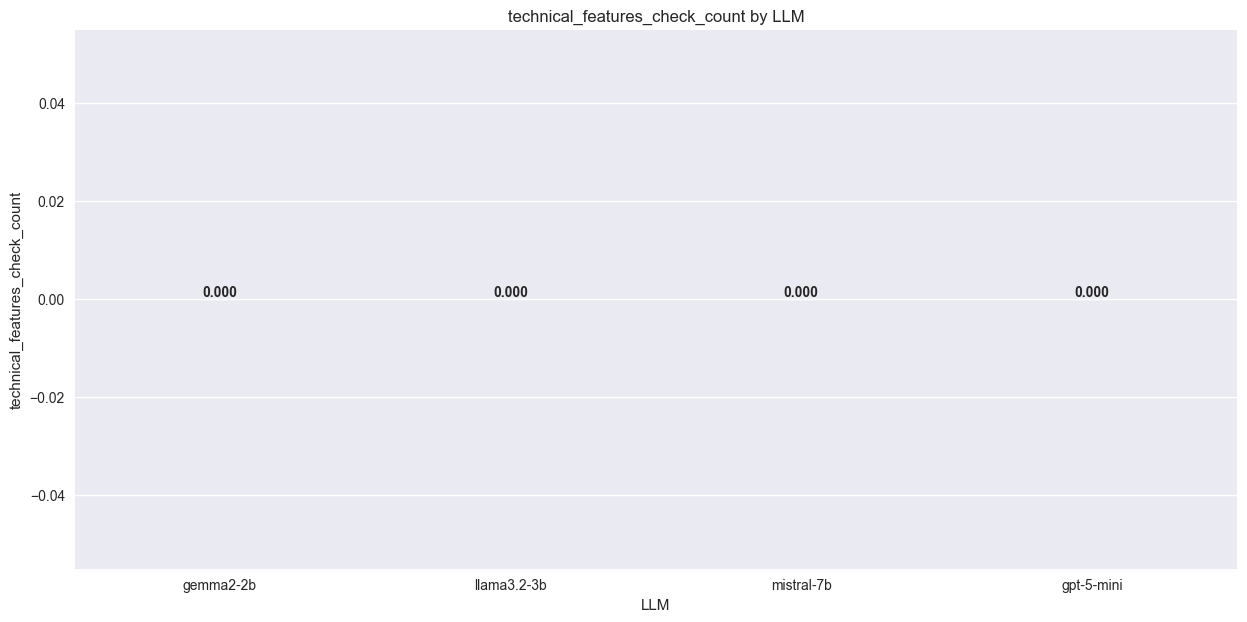

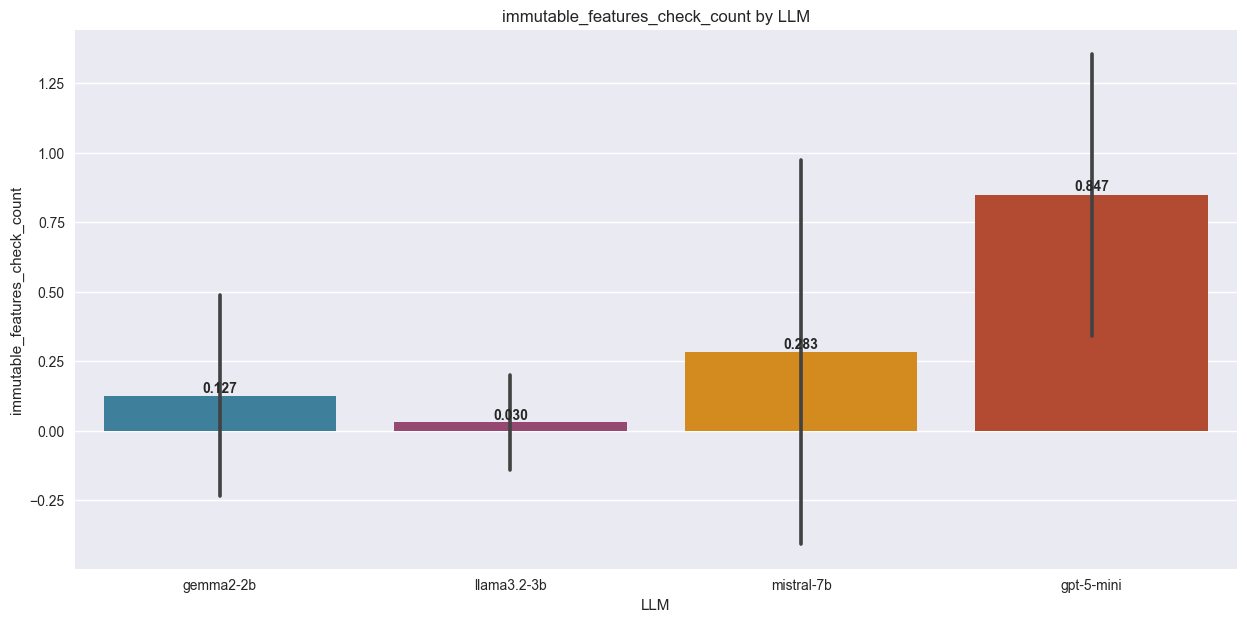

In [ ]:
# Regulatory compliance
print(f"\n=== REGULATORY COMPLIANCE ===")
reg_cols = [
    'principal_reason_identification_score',
    'individual_specific_content_score', 
    'technical_jargon_check_score',
    'technical_features_check_count', 
    'immutable_features_check_count',
    'technical_features_check_found_features',
    'immutable_features_check_mentioned_features'
    ]

feature_lists = ['technical_features_check_found_features', 'immutable_features_check_mentioned_features']



for col in reg_cols:
    if eval_df[col].notna().sum() > 0 and not col.endswith('_features'):
        mean_score = eval_df[col].mean()
        print(f"{col}: {mean_score:.3f}")

# Print barchat with std per LLM

for feature in reg_cols:
    if feature not in feature_lists:
        plot_metric_by_llm(
        eval_df,
        feature,
        f'{feature} by LLM',
        feature,
        format_func=lambda x: f'{x:.3f}',
        show_error_bars=True
)


In [ ]:
# Count the most used technical features
used_features = metadata["used_features"]

eval_df[feature_lists[0]].value_counts()


# Create DataFrames for feature counts per LLM

# Technical Features Count
tech_feature_counts = []
for llm in LLM_ORDER:
    llm_data = eval_df[eval_df['llm_name'] == llm]
    tech_features = llm_data['technical_features_check_found_features'].explode()
    counts = tech_features.value_counts()
    for feature, count in counts.items():
        tech_feature_counts.append({
            'llm_name': llm,
            'feature': feature,
            'count': count,
            'feature_type': 'technical'
        })

# Immutable Features Count
immutable_feature_counts = []
for llm in LLM_ORDER:
    llm_data = eval_df[eval_df['llm_name'] == llm]
    immutable_features = llm_data['immutable_features_check_mentioned_features'].explode()
    # Extract feature names from dictionaries
    feature_names = immutable_features.apply(lambda x: x['feature'] if isinstance(x, dict) and 'feature' in x else None)
    counts = feature_names.value_counts()
    for feature, count in counts.items():
        if feature is not None:  # Skip None values
            immutable_feature_counts.append({
                'llm_name': llm,
                'feature': feature,
                'count': count,
                'feature_type': 'immutable'
            })

# Combine into single DataFrame
feature_counts_df = pd.DataFrame(tech_feature_counts + immutable_feature_counts)

# Pivot for easier plotting
tech_pivot = feature_counts_df[feature_counts_df['feature_type'] == 'technical'].pivot(
    index='feature', columns='llm_name', values='count'
).fillna(0)

immutable_pivot = feature_counts_df[feature_counts_df['feature_type'] == 'immutable'].pivot(
    index='feature', columns='llm_name', values='count'
).fillna(0)

# Reorder columns to match LLM_ORDER and convert counts to percentages
# (Assuming 3 samples per LLM, so divide by 3 and multiply by 100)
if not tech_pivot.empty:
    tech_pivot_pct = (tech_pivot[LLM_ORDER] / 300 * 100).round(1)
    print("Technical Features Mentioned (% of samples):")
    display(tech_pivot_pct.style.format("{:.1f}%"))

if not immutable_pivot.empty:
    immutable_pivot_pct = (immutable_pivot[LLM_ORDER] / 300 * 100).round(1)
    print("\nImmutable Features Mentioned (% of samples):")
    display(immutable_pivot_pct.style.format("{:.1f}%"))

# Display same explanations using age

# Print some explanations where immutable features were mentioned in the explanations
for llm in LLM_ORDER:
    print(f"\n{llm}:")
    # Get explanations where at least one immutable feature was mentioned
    llm_df = eval_df[(eval_df['llm_name'] == llm) & (eval_df["prediction_outcome"] == 'declined') & (eval_df['immutable_features_check_mentioned_features'].apply(lambda x: isinstance(x, list) and len(x) > 1))]
    # Show up to 3 such explanations
    for i, row in llm_df.head(3).iterrows():
        print(row['explanation_text'])
        print("-" * 100)


Immutable Features Mentioned (% of samples):


llm_name,gemma2-2b,llama3.2-3b,mistral-7b,gpt-5-mini
feature,,,,
NumberOfDependents,1.0%,0.0%,9.3%,4.0%
age,11.7%,3.0%,16.3%,79.0%
imputed_income,0.0%,0.0%,2.7%,1.7%



gemma2-2b:
{"consumer_explanation": "It seems like your credit decision was based on a few key factors. The most important factor that impacted your application is your credit card usage, which currently sits at 64.9%. This means you're using a significant portion of your available credit limit. To improve your chances of approval in the future, consider aiming for a credit card utilization rate closer to 10% or less.  Think about paying down existing balances and being mindful of how much you use your cards each month.    Another important factor is your debt-to-income ratio, which currently sits at 69.8%. This means that you're spending a large portion of your income on debt payments. While this isn't necessarily a dealbreaker, it can make loan applications more challenging to get approved for. To improve your situation, consider exploring ways to reduce your monthly expenses and increase your income.    Remember, even small changes can have a big impact! For example, if you were ab

## SemScore analysis

In [ ]:
# Load semscore analysis from summary_stats
semscore_analysis = summary_stats['semscore_analysis']

# Define metric mapping (display name -> data keys)
METRIC_MAPPING = {
    'Random Baseline (Mean)': ('random_baseline', 'mean'),
    'Inter-cluster (Mean)': ('inter_cluster_similarity', 'mean'),
    'Intra-cluster (Mean)': ('intra_cluster_similarity', 'mean'),
    'Same Instance (Mean)': ('same_instance_similarity', 'mean'),
    # 'Random Baseline (Std)': ('random_baseline', 'std'),
    # 'Inter-cluster (Std)': ('inter_cluster_similarity', 'std'),
    # 'Intra-cluster (Std)': ('intra_cluster_similarity', 'std'),
    # 'Same Instance (Std)': ('same_instance_similarity', 'std'),
}

# Create DataFrame using nested dictionary comprehension
semscore_data = {
    (outcome, metric): {
        llm: (
            f"{semscore_analysis['by_llm_and_outcome'][llm][outcome][data_key][stat_type]:.4f}"
            if llm in semscore_analysis['by_llm_and_outcome']
            and outcome in semscore_analysis['by_llm_and_outcome'][llm]
            and semscore_analysis['by_llm_and_outcome'][llm][outcome][data_key]['count'] > 0
            else 'N/A'
        )
        for llm in LLM_ORDER
    }
    for outcome in ['approved', 'declined']
    for metric, (data_key, stat_type) in METRIC_MAPPING.items()
}

# Create DataFrame from nested dict and transpose
semscore_df = pd.DataFrame.from_dict(semscore_data, orient='index')
semscore_df.index.names = ['Outcome', 'Metric']

# Display the summary table
print(f"\nSemScore Analysis Summary (LLMs as columns)")
print(f"Total metrics analyzed: {len(semscore_df)}")
print()

display(semscore_df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).format(precision=4))

# Export to Excel
if save_plots:
    excel_path = f'{output_dir}/evaluations/semscore_analysis_summary.xlsx'
    semscore_df.to_excel(excel_path, sheet_name='SemScore Analysis')
    print(f"\n📁 SemScore analysis exported to: {excel_path}")


SemScore Analysis Summary (LLMs as columns)
Total metrics analyzed: 8




📁 SemScore analysis exported to: ../output/evaluations/semscore_analysis_summary.xlsx


## 5. Technical feasibility

In [ ]:
# Other metrics
other_score_cols = [col for col in eval_df.columns if col.endswith('_score') and 
                    not any(x in col for x in ['cemat', 'regulatory', 'cf_'])]
for col in other_score_cols:
    if eval_df[col].notna().sum() > 0:
        mean_score = eval_df[col].mean()
        print(f"{col}: {mean_score:.3f}")

principal_reason_identification_score: 0.931
individual_specific_content_score: 0.980
technical_jargon_check_score: 0.739
fidelity_score: 0.800
flesch_kincaid_score: 0.487


In [ ]:
# Load explanation data with processing times
with open('../output/llm_explanations/explanations.json', 'r') as f:
    explanation_data = json.load(f)

explanations = explanation_data['explanations']

# Extract processing times per LLM
processing_times = []
for exp in explanations:
    processing_times.append({
        'llm_name': exp['llm_name'],
        'processing_time': exp['processing_time'],
        'regeneration_number': exp['regeneration_number']
    })

df_times = pd.DataFrame(processing_times)

# Calculate statistics
stats_by_llm = df_times.groupby('llm_name')['processing_time'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)

print("📊 LLM Processing Time Statistics (seconds)")
print("=" * 55)
print(stats_by_llm.to_string())

# Calculate total processing time
total_time = df_times['processing_time'].sum()
total_hours = total_time / 3600
print(f"\n⏱️ Total Processing Time: {total_time:.0f} seconds ({total_hours:.1f} hours)")
print(f"📈 Dataset: {len(explanations):,} explanations across {df_times['llm_name'].nunique()} LLMs")

📊 LLM Processing Time Statistics (seconds)
             count    mean    std    min     max  median
llm_name                                                
gemma2-2b      300   15.15   8.14   5.80   67.06   13.37
gpt-5-mini     300   28.84   7.21  15.14   66.34   27.61
llama3.2-3b    300   20.10  11.97   5.41   78.61   16.45
mistral-7b     300  250.98  38.12  36.23  335.90  247.98

⏱️ Total Processing Time: 94521 seconds (26.3 hours)
📈 Dataset: 1,200 explanations across 4 LLMs


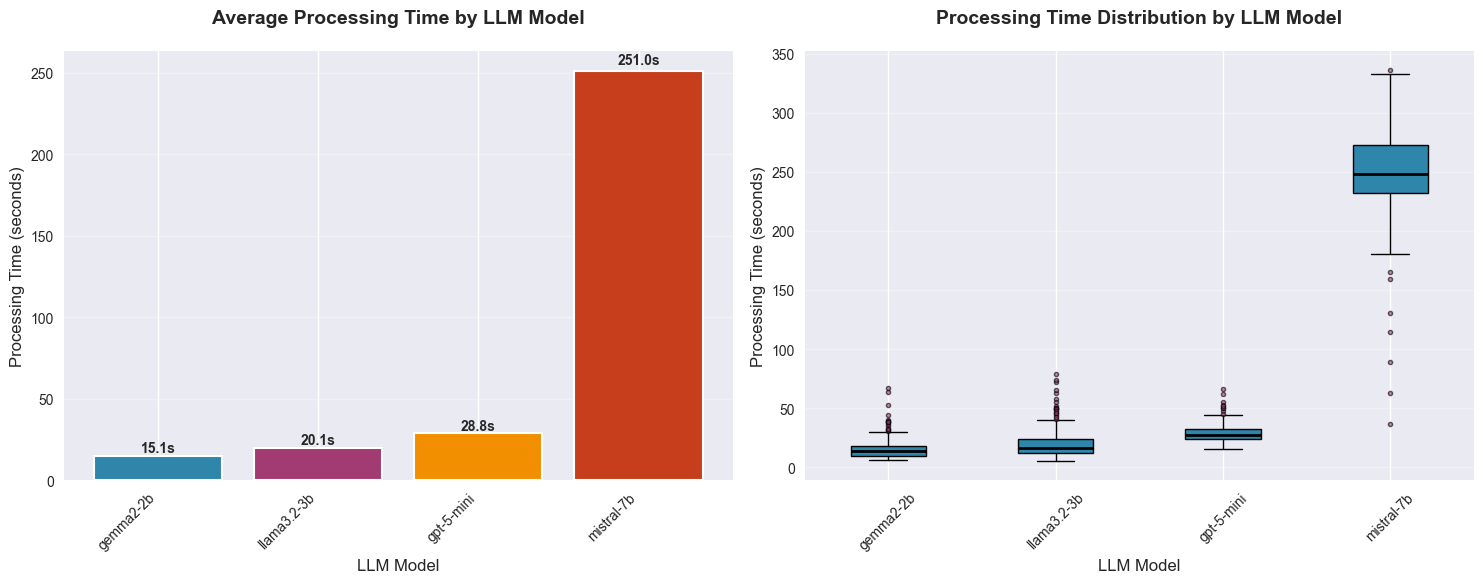

📊 Chart saved to: ../output/plots/llm_processing_times.png


<Figure size 1500x700 with 0 Axes>

In [ ]:
# Create academic-style visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Average Processing Time by LLM (Bar Chart)
avg_times = df_times.groupby('llm_name')['processing_time'].mean().sort_values()
colors = [COLORS['bar'], COLORS['accent'], COLORS['neutral'], COLORS['highlight']]

bars = ax1.bar(range(len(avg_times)), avg_times.values, color=colors, alpha=ALPHA, 
               edgecolor='white', linewidth=1.5)
ax1.set_title('Average Processing Time by LLM Model', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('LLM Model', fontsize=12)
ax1.set_ylabel('Processing Time (seconds)', fontsize=12)
ax1.set_xticks(range(len(avg_times)))
ax1.set_xticklabels(avg_times.index, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Processing Time Distribution (Box Plot)
df_times_sorted = df_times.copy()
df_times_sorted['llm_name'] = pd.Categorical(df_times_sorted['llm_name'], 
                                           categories=avg_times.index, ordered=True)

box_plot = ax2.boxplot([df_times[df_times['llm_name'] == llm]['processing_time'].values 
                        for llm in avg_times.index], 
                       tick_labels=avg_times.index, patch_artist=True, 
                       boxprops=dict(facecolor=COLORS['bar'], alpha=ALPHA),
                       medianprops=dict(color='black', linewidth=2),
                       flierprops=dict(marker='o', markerfacecolor=COLORS['accent'], 
                                     markersize=3, alpha=0.6))

ax2.set_title('Processing Time Distribution by LLM Model', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('LLM Model', fontsize=12)
ax2.set_ylabel('Processing Time (seconds)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

if save_plots:
    plt.savefig(f'{output_dir}/plots/llm_processing_times.png', dpi=300, bbox_inches='tight')
    print(f"📊 Chart saved to: {output_dir}/plots/llm_processing_times.png")